In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tensorflow import set_random_seed
# for reproducibility 
np.random.seed(1)
set_random_seed(1)

from keras.layers import Dense, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Dropout, Activation, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [11]:
# Build a classifier with outlier samples from the rectangle

class Classifier:

    # 3 Class classifier - class 2 represents outliers and class 0,1 represent inliers.
    # Class 0 sampled from a circle centered at (x, y) = (-2, 0) with radius 0.5
    # Class 1 sampled from a circle centered at (x, y) = (+2, 0) with radius 0.5
    # Class 2 sampled from rectagle with origin (x, y) = (-3, -1) with h=2, w=6 excluding regions covered by inliers.

    # Generate n points uniformly within a circle of radius r, centered at (x, y)
    # return as a numpy array n x 2 of dtype = float32
    def __init__(self):
        self.number_of_classes = 3
        self.input_dim = 2
        self.epochs = 100
        self.batch_size = 32
        self.data, self.labels = self.get_data()
        print(self.data.shape, self.labels.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.labels, test_size=0.5, shuffle=True, stratify=self.labels,
                                                            random_state=1)
        self.model = self.get_model()

        
        self.mu = np.mean(self.X_train, axis=0)
        self.sigma = np.std(self.X_train, axis=0)

        self.data = self.preprocess_data(self.data)
        self.X_train = self.preprocess_data(self.X_train)
        self.X_test = self.preprocess_data(self.X_test)


    def preprocess_data(self, x):
        return (x-self.mu)/self.sigma


    def get_circle_data(self, x, y, r, n):
        rho = np.sqrt(np.random.uniform(0, r, n))
        phi = np.random.uniform(0, 2*np.pi, n)

        data = np.zeros((n, 2))
        data[:, 0] = rho * np.cos(phi) + x
        data[:, 1] = rho * np.sin(phi) + y
        data = data.astype(np.float32)
        return data
        # plt.scatter(x, y, s = 4)
    
    # return True if point (x1, y1) lies inside a circle defined by (x, y, r+0.1)
    def is_in_circle(self, x, y, r, x1, y1):
        return (x-x1)**2 + (y-y1)**2 <= (r+0.1)**2

    
    # generate n outlier points uniformly sampled within rectagle (x1, y1), (h, w) excuding the inlier circles
    def get_outlier_data(self, x1, y1, h, w, cx1, cy1, r1, cx2, cy2, r2, n):
        count = 0
        data = np.zeros((n, 2))
        while count < n:
            x = np.random.uniform(x1, x1+w, 1)
            y = np.random.uniform(y1, y1+h, 1)
            if (not self.is_in_circle(cx1, cy1, r1, x, y)) and (not self.is_in_circle(cx2, cy2, r2, x, y)):
                data[count,0] = x
                data[count,1] = y
                count += 1
        return data
        
    def get_data(self):
        # class 0 data
        data = self.get_circle_data(-2, 0, 1, 1000)
        labels = np.ones((1000, 1))*0
        print(labels.shape)
        # class 1 data
        data = np.concatenate((data, self.get_circle_data(+2, 0, 1, 1000)), axis=0)
        labels = np.concatenate((labels, np.ones((1000, 1))*1), axis=0)
        print(labels.shape)
        # outlier data
        data = np.concatenate((data, self.get_outlier_data(-10, -4, 8, 20, -2, 0, 1, +2, 0, 1, 1000)), axis=0)
        labels = np.concatenate((labels, np.ones((1000,1))*2), axis=0)
        print(labels.shape)
        return data.astype(np.float32), labels.astype(np.float32)
    
    def get_model(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(self.input_dim,)))
        model.add(Activation('relu'))
        model.add(Dense(256))
        model.add(Activation('relu'))
        model.add(Dense(self.number_of_classes))
        # model.add(Convolution2D(10,3,3, border_mode='same'))
        # model.add(GlobalAveragePooling2D())
        model.add(Activation('softmax'))
        model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
        return model


    def train(self):
        # fit the model
        Y_train = np_utils.to_categorical(self.y_train, self.number_of_classes)#[0:59968,]
        Y_test = np_utils.to_categorical(self.y_test, self.number_of_classes)
        self.model.fit(self.X_train, Y_train, epochs=self.epochs, validation_data=(self.X_test, Y_test), batch_size=self.batch_size)


In [12]:
classifier = Classifier()

classifier.train()

(1000, 1)
(2000, 1)
(3000, 1)
((3000, 2), (3000, 1))
Train on 1500 samples, validate on 1500 samples
Epoch 1/100
1500/1500 [==============================] - 0s 145us/step - loss: 0.4175 - acc: 0.8189 - val_loss: 0.2508 - val_acc: 0.9591
Epoch 2/100
1500/1500 [==============================] - 0s 41us/step - loss: 0.1461 - acc: 0.9744 - val_loss: 0.0724 - val_acc: 0.9838
Epoch 3/100
1500/1500 [==============================] - 0s 40us/step - loss: 0.0601 - acc: 0.9829 - val_loss: 0.0417 - val_acc: 0.9889
Epoch 4/100
1500/1500 [==============================] - 0s 42us/step - loss: 0.0460 - acc: 0.9867 - val_loss: 0.0366 - val_acc: 0.9898
Epoch 5/100
1500/1500 [==============================] - 0s 42us/step - loss: 0.0382 - acc: 0.9884 - val_loss: 0.0351 - val_acc: 0.9933
Epoch 6/100
1500/1500 [==============================] - 0s 41us/step - loss: 0.0355 - acc: 0.9887 - val_loss: 0.0305 - val_acc: 0.9933
Epoch 7/100
1500/1500 [==============================] - 0s 47us/step - loss: 0.03

1500/1500 [==============================] - 0s 42us/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0062 - val_acc: 0.9978
Epoch 61/100
1500/1500 [==============================] - 0s 42us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0136 - val_acc: 0.9951
Epoch 62/100
1500/1500 [==============================] - 0s 40us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0077 - val_acc: 0.9969
Epoch 63/100
1500/1500 [==============================] - 0s 38us/step - loss: 0.0031 - acc: 0.9987 - val_loss: 0.0116 - val_acc: 0.9960
Epoch 64/100
1500/1500 [==============================] - 0s 38us/step - loss: 0.0059 - acc: 0.9978 - val_loss: 0.0125 - val_acc: 0.9964
Epoch 65/100
1500/1500 [==============================] - 0s 38us/step - loss: 0.0066 - acc: 0.9973 - val_loss: 0.0063 - val_acc: 0.9973
Epoch 66/100
1500/1500 [==============================] - 0s 38us/step - loss: 0.0043 - acc: 0.9982 - val_loss: 0.0114 - val_acc: 0.9960
Epoch 67/100
1500/1500 [==============================

In [13]:
# Plot input data

plt.scatter(classifier.data[:, 0], classifier.data[:, 1], s=4, c=classifier.labels.squeeze())
print("Plot of input data")

Plot of input data


<IPython.core.display.Javascript object>


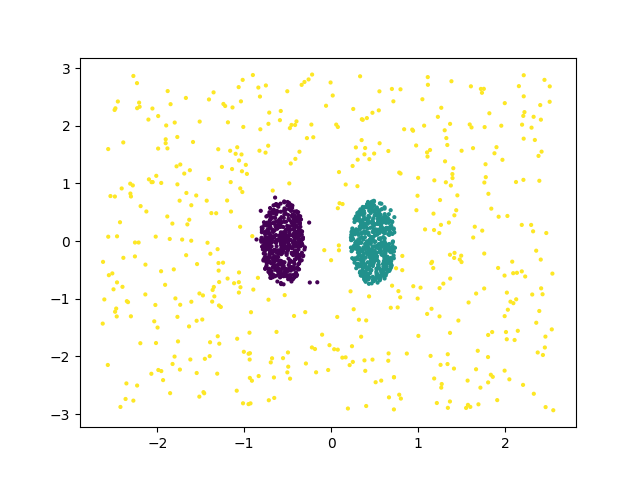

In [14]:
# Plot classified data - for test data

y_pred = classifier.model.predict(classifier.X_test)
y_max = y_pred.max(axis = -1)
y_labels = y_pred.argmax(axis = -1)

fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig)

#ax.scatter(classifier.X_test[:, 0], classifier.X_test[:, 1], y_max, c=classifier.y_test.squeeze())
plt.scatter(classifier.X_test[:, 0], classifier.X_test[:, 1], s=4, c=y_labels.squeeze())

In [15]:
print(classifier.X_test.shape)

(1500, 2)
